# QFT Simulation and real quantum hardware

In this notebook, you will run both the QFT and its inverse against real and simulated quantum hardware. You will be using some of your answers from HW10.2. The code around QFT, inverse QFT, executing simulations, and jobs has been provided for you. Your job will be to figure out how to manipulate the `QuantumCircuit` object to construct the desired circuits.

**Note**: Qiskit's least significant bit has the lowest index (0), thus the circuit will be mirrored through the horizontal. See section 5 from the class notebook for more information.

## Problem 0: Setup Account
Before we do any real programming, we need to setup your [IBMQ](https://quantum-computing.ibm.com/) account. Accounts are free. Once you have created your account, access your API token, which can be found in your account settings. Copy this (and ONLY this) to a file 'token.txt' in the same directory as this notebook. The following code will run successfully when this has been complete.

In [2]:
### START DO NOT CHANGE ###
import os.path
assert os.path.exists('token.txt')
### END DO NOT CHANGE ###

The following is a bunch of helper code, do **not** change!

In [3]:
### START DO NOT CHANGE ###
import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
# Common variables
nqubits = 3
shots = 2048
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits 
    # NOTE: we reduced n by one earlier in the function
    qft_rotations(circuit, n)

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit.decompose() # .decompose() allows us to see the individual gates

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

def load_IBMQ():
    with open('token.txt') as f:
        token = f.read()
        IBMQ.save_account(token, overwrite=True)
    IBMQ.load_account()

    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
    
    return provider, backend


def simulate(circuit):
    qc = circuit.copy()
    qobj = assemble(qc, shots=shots)
    job = sim.run(qobj)
    job_monitor(job)
    return job.result().get_counts()


def run_job(circuit):
    qc = circuit.copy()
    transpiled_qc = transpile(qc, backend, optimization_level=3)
    job = backend.run(transpiled_qc, shots=shots)
    job_monitor(job)

    return job.result().get_counts()

provider, backend = load_IBMQ()
sim = Aer.get_backend("aer_simulator")

### END DO NOT CHANGE ###

# 1: Apply the QFT to 3-qubit state $|2 \rangle$

Your task here is to generate the circuit that constructs the computationl basis state $| 2 \rangle$. 

### Determine what $|2 \rangle$ is a separable 3-qubit state.


|010> is the |2> state using 3 qubits.
 

### Fill in the `prepare_state_2` method below by adding the required gate(s) to the `circuit` object.

In [4]:
def prepare_state_2(circuit):
# YOUR CODE START
    circuit.prepare_state(2)
    return circuit #!!! UNCOMMENT THIS LINE WHEN YOU HAVE WRITTEN THIS METHOD !!!

# YOUR CODE END

Once this method has been correctly created, we will construct the circuit for the full state preparation and QFT

In [5]:
### BEGIN DO NOT CHANGE ###
qc = QuantumCircuit(3)
qc = prepare_state_2(qc)
qc = qft(qc, 3)
qc.measure_all()
### END DO NOT CHANGE ###

### Run this circuit against both the Aer simulator and on the actual quantum system

In [6]:
# BEGIN your code

counts_simulated = simulate(qc)
counts_real = run_job(qc)

# END your code

Job Status: job has successfully run
Job Status: job has successfully run


### Plot your results

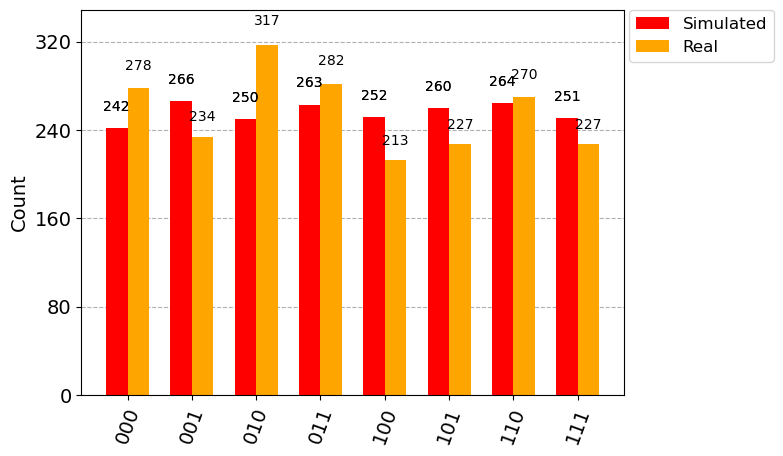

In [7]:
# BEGIN your code

plot_histogram([counts_simulated, counts_real], legend=['Simulated', 'Real'], color=['red', 'orange'])

# END your code

### Discuss how this histogram relates to your answer from 2b



The QFT successfully was applied as every Qubit is now in some differing rotation. 
 


## 2: Apply the inverse QFT to state $| \tilde{7} \rangle$

In the class exercise, we covered preparing and running the inverse QFT on the state $| \tilde{5} \rangle$. Your task is to run the inverse QFT on $| \widetilde{7} \rangle$.

### Using your answer from 10.2d, fill out the method `prepare_fstate_7` below.

In [8]:
def prepare_fstate_7(circuit):
# YOUR CODE START
    circuit.prepare_state(7)
    circuit = qft(circuit,3)
    
# YOUR CODE END
    return circuit 

If your method is correct, the following code will print out the correct circuit for $| \tilde{7} \rangle$.

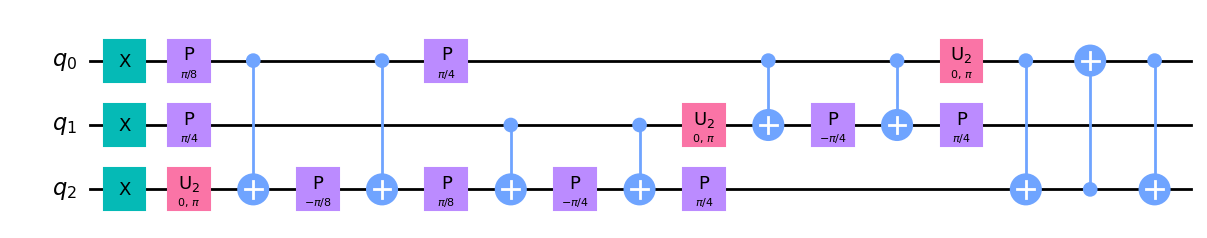

In [9]:
### BEGIN DO NOT CHANGE ###
qc = QuantumCircuit(3)
qc = prepare_fstate_7(qc)
qc.draw('mpl')
### END DO NOT CHANGE ###

### Run this circuit against both the Aer simulator and on the actual quantum system

In [10]:
### BEGIN DO NOT CHANGE ###
qc = inverse_qft(qc, nqubits)
qc.measure_all()
### END DO NOT CHANGE ###

# BEGIN your code

counts_simulated = simulate(qc)
counts_real = run_job(qc)

# END your code

Job Status: job has successfully run
Job Status: job has successfully run


### Plot your results

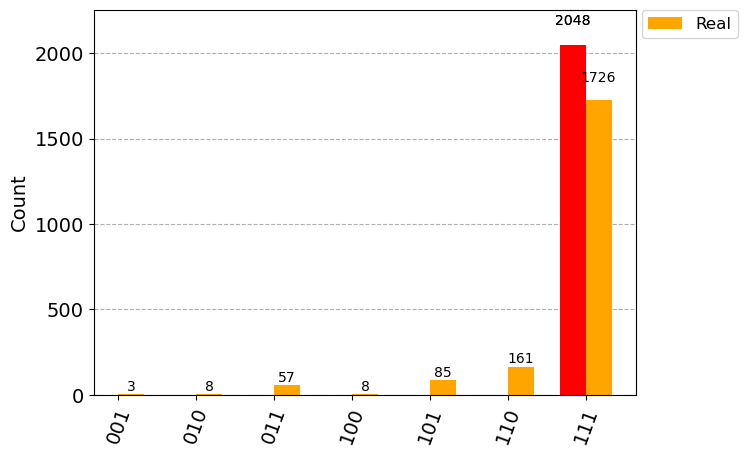

In [11]:
# BEGIN your code

plot_histogram([counts_simulated, counts_real], legend=['Simulated', 'Real'], color=['red', 'orange'])

# END your code

## What state has the highest probability and why? Is this 100%? Why or why not?



The highest probability is |111> due to the QFT having run and been inversed. This is what the Qubits will be measured as due to the transference to from the computational basis to the fourier basis back to the computaitonal basis. The number 7 has been returned.


## References<a id="references"></a>

1. M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).
2. [QFT Qiskit tutorital](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html)

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table